In [1]:
import pickle
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import seaborn as sns

import scienceplots
#plt.style.use(['science', 'ieee', 'notebook'])

In [2]:
binary = os.path.join(os.getcwd(), 'data', 'volve_compiled.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    data = pickle.load(bin_file)

/mnt/d/OneDrive/Mestrado/gits/sklearn-sid/Volve-Dataset/data/volve_compiled.pkl


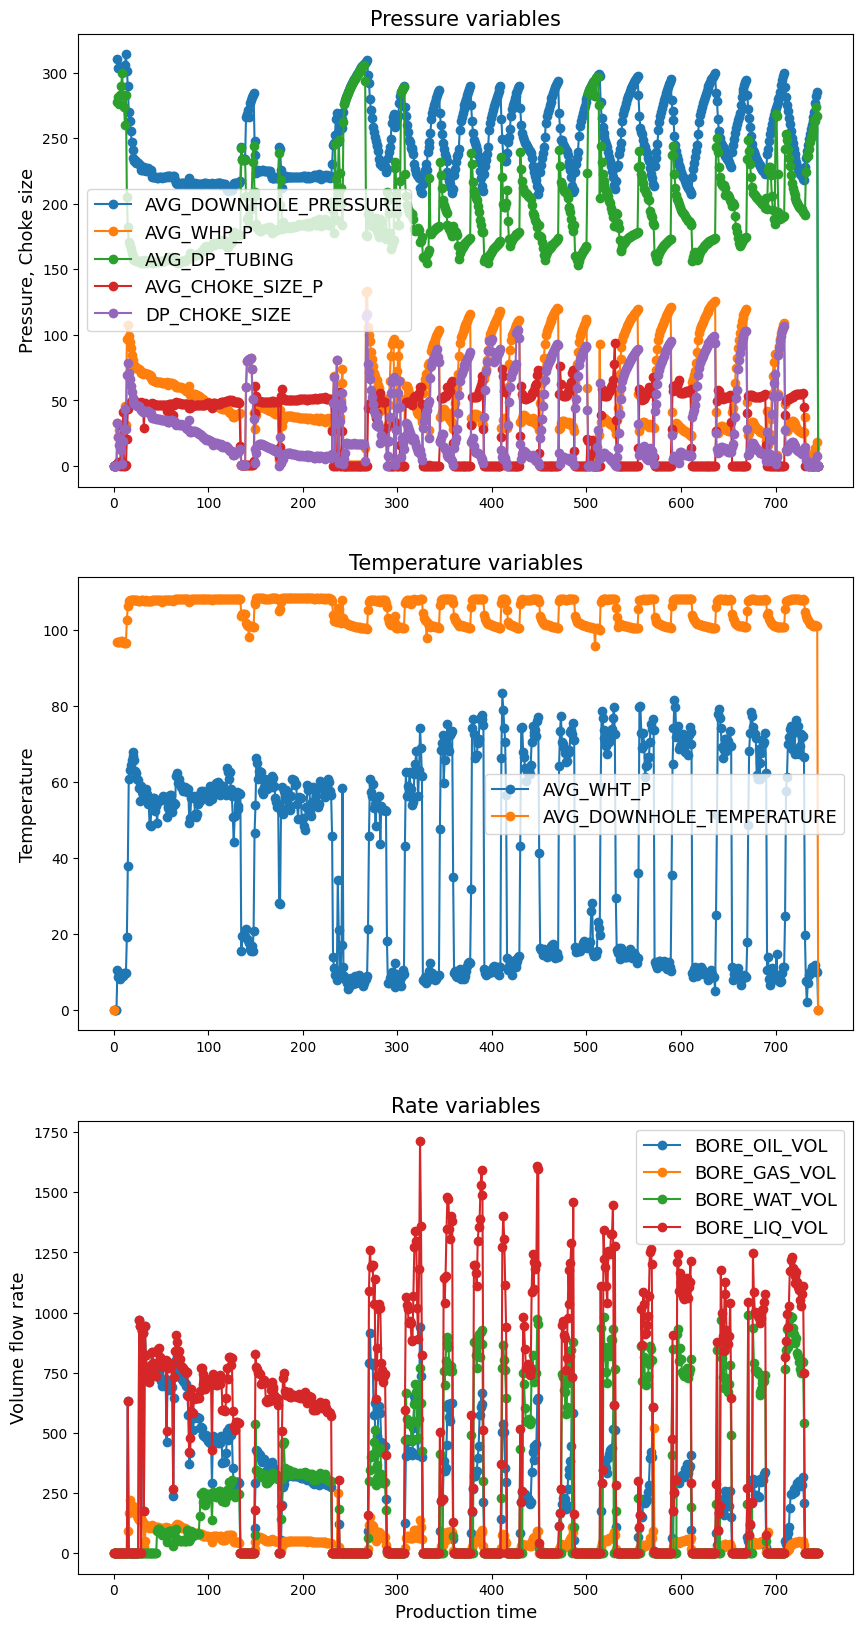

In [3]:
case = "15/9-F-1 C"
#case = "15/9-F-11"

data_case = data['OP'][case]

filt_vars_IN_Q =  [
        'BORE_OIL_VOL',
        'BORE_GAS_VOL',
        'BORE_WAT_VOL',
        #'BORE_OIL_CUM',
        #'BORE_LIQ_CUM',
        #'BORE_GAS_CUM',
        #'BORE_WAT_CUM',
]

filt_vars_IN_QINJ = [
        #'BORE_WI_VOL',
        #'BORE_WI_CUM',
]

filt_vars_IN_P = [
        'AVG_DOWNHOLE_PRESSURE',
        'AVG_WHP_P',
        'AVG_DP_TUBING',
        #'AVG_ANNULUS_PRESS',
        'AVG_CHOKE_SIZE_P',
        'DP_CHOKE_SIZE',
]

filt_vars_IN_T = [
        'AVG_WHT_P',
        'AVG_DOWNHOLE_TEMPERATURE',
]

filt_vars_OUT = [
        'BORE_OIL_VOL',
        'BORE_GAS_VOL',
        'BORE_WAT_VOL',
        'BORE_LIQ_VOL',
]

time = data_case['N']
fig, ax = plt.subplots(3,1, figsize=(10, 20))
for var in filt_vars_IN_P:
    ax[0].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_T:
    ax[1].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_OUT:
    ax[2].plot(time, data_case[var], '-o', label=var)
#for var in filt_vars_OUT:
#    ax[3].plot(time, data_case[var], '-o', label=var)
title_font = 15
label_font = 13
ax[0].set_title(f'Pressure variables', fontsize=title_font)
ax[1].set_title(f'Temperature variables', fontsize=title_font)
ax[2].set_title(f'Rate variables', fontsize=title_font)
ax[0].set_ylabel('Pressure, Choke size', fontsize=label_font)
ax[1].set_ylabel('Temperature', fontsize=label_font)
ax[2].set_ylabel('Volume flow rate', fontsize=label_font)
ax[2].set_xlabel('Production time', fontsize=label_font)
ax[0].legend(fontsize=label_font)
ax[1].legend(fontsize=label_font)
ax[2].legend(fontsize=label_font)

fig.savefig('data/data_example.pdf',  bbox_inches = "tight")

In [4]:
prefix = 'SISO-static.W1'
binary = os.path.join(os.getcwd(), 'outputs', 'test_runs', f'{prefix}_ml.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    X1_tr, y_tr, X1_te, y_te, results, order_progression = pickle.load(bin_file)

/mnt/d/OneDrive/Mestrado/gits/sklearn-sid/Volve-Dataset/outputs/test_runs/SISO-static.W1_ml.pkl


In [5]:
model_pars = []
best_pars = []
yhats = []
lags = []
for index, row in pd.DataFrame(results).iloc[2:,:].iterrows():
    yhats.append([f"{row['MODEL']}.{prefix}",row['MODEL OBJ'].predict(X1_te, y_te),row['MODEL OBJ'].predict(X1_te, y_te, steps_ahead=1)])
    try:
        model_pars.append((f"{row['MODEL']}.{prefix}", row['MODEL OBJ'].estimator.cv_results_))
        best_pars.append((f"{row['MODEL']}.{prefix}", row['MODEL OBJ'].estimator.best_params_))
        lags.append((f"{row['MODEL']}.{prefix}", row['MODEL OBJ'].nX))
    except Exception as e: 
        print(e)


In [6]:
prefix = 'MISO-static.W1'
binary = os.path.join(os.getcwd(), 'outputs', 'test_runs', f'{prefix}_ml.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    X1_tr, y_tr, X1_te, y_te, results, order_progression = pickle.load(bin_file)

/mnt/d/OneDrive/Mestrado/gits/sklearn-sid/Volve-Dataset/outputs/test_runs/MISO-static.W1_ml.pkl


In [7]:
for index, row in pd.DataFrame(results).iloc[2:,:].iterrows():
    yhats.append([f"{row['MODEL']}.{prefix}",row['MODEL OBJ'].predict(X1_te, y_te),row['MODEL OBJ'].predict(X1_te, y_te, steps_ahead=1)])
    try:
        model_pars.append((f"{row['MODEL']}.{prefix}", row['MODEL OBJ'].estimator.cv_results_))
        best_pars.append((f"{row['MODEL']}.{prefix}", row['MODEL OBJ'].estimator.best_params_))
        lags.append((f"{row['MODEL']}.{prefix}", row['MODEL OBJ'].nX))
    except Exception as e: 
        print(e)

In [8]:
cv_errors = {
    'MODEL' : [],
    'INPUTS': [],
    'SPLIT' : [],
    'R2 SCORE': [],
            }

mlp_data = {
    'INPUTS' : [],
    'R2 MEAN SCORE' : [],
    'R2 STD DEV' : []
    }

times = {
    'MODEL':[],
    'INPUTS': [],
    'TIME MEAN' :[],
    'TIME STD': []
}
for model, model_par in model_pars:
    if 'MLP' in model:
        r2_scores = model_par['mean_test_score'].tolist()
        r2_scores_std = model_par['std_test_score'].tolist()
        n_r2 = len(r2_scores)
        mlp_data['INPUTS'].extend([model.split('.')[1]]*n_r2)
        mlp_data['R2 MEAN SCORE'].extend(r2_scores)
        mlp_data['R2 STD DEV'].extend(r2_scores_std)
    best_model = np.where(model_par['rank_test_score'] == 1)[0]
    times['MODEL'].append(model.split('.')[0])
    times['INPUTS'].append(model.split('.')[1])
    times['TIME MEAN'].append(model_par['mean_fit_time'][best_model][0])
    times['TIME STD'].append(model_par['std_fit_time'][best_model][0])
    for key in model_par.keys():
        if 'split' in key and '_test_score' in key:
            cv_errors['MODEL'].append(model.split('.')[0])
            cv_errors['INPUTS'].append(model.split('.')[1])
            cv_errors['SPLIT'].append(int(key.split('_')[0][5:]))
            cv_errors['R2 SCORE'].append(model_par[key][best_model][0])
        elif 'MLP' in model and 'param_' in key:
            pname = key[6:]
            if not pname in mlp_data.keys():
                try:
                    mlp_data[pname] = model_par[key].tolist()
                except Exception:
                    mlp_data[pname] = model_par[key]
            else:
                try:
                    mlp_data[pname].extend(model_par[key].tolist())
                except Exception:
                    mlp_data[pname].extend(model_par[key])
            
            

cv_errors = pd.DataFrame(cv_errors)
mlp_data['hidden_layers'] = [len(x) for x in mlp_data['hidden_layer_sizes']]
mlp_data['total_hidden_units'] = [np.sum(x) for x in mlp_data['hidden_layer_sizes']]
mlp_data = pd.DataFrame(mlp_data)
mlp_data.drop(columns=['activation', 'max_iter', 'solver'], inplace=True)
display(mlp_data)

INPUTS  R2 MEAN SCORE  R2 STD DEV     alpha  batch_size   
0    SISO-static       0.785566    0.046466  0.030304         256  \
1    SISO-static       0.873268    0.035423  0.034329          32   
2    SISO-static       0.837393    0.037064  0.086851         128   
3    SISO-static       0.855500    0.051966  0.004190          32   
4    SISO-static       0.851722    0.042628  0.001361          32   
..           ...            ...         ...       ...         ...   
195  MISO-static       0.777353    0.042565  0.348421          32   
196  MISO-static       0.840764    0.052835  0.000114          64   
197  MISO-static       0.853621    0.039935  0.053043          32   
198  MISO-static       0.844742    0.055020  0.023639         256   
199  MISO-static       0.859947    0.039146  0.043703          64   

     early_stopping hidden_layer_sizes           tol  hidden_layers   
0             False  (80, 40, 40, 100)  3.019659e-03              4  \
1              True   (80, 80, 20, 20)  1.643129e-05              4   
2             False  (20, 100, 40, 60)  2.306157e-06              4   
3             False      (60, 40, 100)  1.917448e-06              3   
4              True          (60, 100)  3.058823e-04              2   
..              ...                ...           ...            ...   
195           False  (100, 60, 60, 20)  2.154966e-02              4   
196           False   (20, 80, 60, 60)  1.092597e-06              4   
197           False  (100, 60, 40, 80)  1.110901e-05              4   
198           False   (80, 80, 60, 40)  8.299463e-07              4   
199           False       (40, 80, 40)  1.633811e-05              3   

     total_hidden_units  
0                   260  
1                   200  
2                   220  
3                   200  
4                   160  
..                  ...  
195                 240  
196                 220  
197                 280  
198                 260  
199                 160  

[200 rows x 10 columns]

/tmp/ipykernel_27205/2714026590.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(axs.get_xticklabels(),rotation=90)


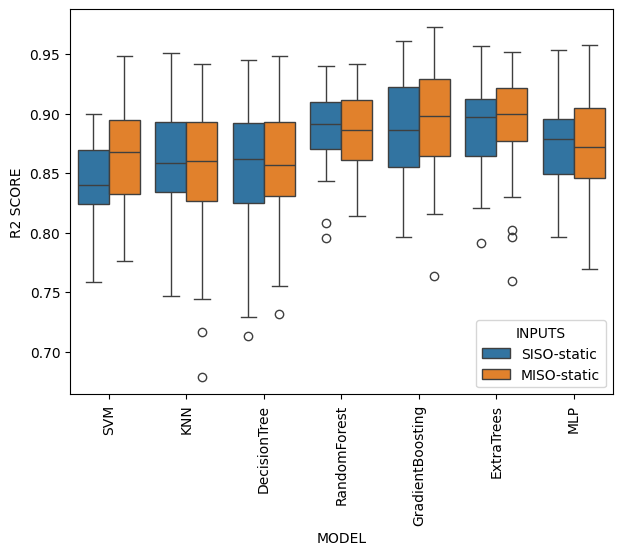

In [9]:
#plt.style.use(['science', 'ieee', 'notebook'])
cv_errors_filt = cv_errors[
    (cv_errors.MODEL == 'LinReg')|
    (cv_errors.MODEL == 'PolyReg')|
    (cv_errors.MODEL == 'MLP')
]
fig, axs = plt.subplots(1,1, figsize=(7,5))
sns.boxplot(data=cv_errors, x='MODEL', y='R2 SCORE', hue='INPUTS', ax=axs)
axs.set_xticklabels(axs.get_xticklabels(),rotation=90)
fig.savefig('./outputs/final_results/boxplot-static_cv.pdf', bbox_inches = "tight")

In [10]:
pd.DataFrame(times)

MODEL       INPUTS  TIME MEAN  TIME STD
0                SVM  SISO-static   0.007368  0.001723
1                KNN  SISO-static   0.000764  0.000216
2       DecisionTree  SISO-static   0.001165  0.000218
3       RandomForest  SISO-static   0.400217  0.052678
4   GradientBoosting  SISO-static   0.863575  0.038739
5         ExtraTrees  SISO-static   0.098246  0.014183
6                MLP  SISO-static   0.468467  0.221618
7                SVM  MISO-static   0.003896  0.000837
8                KNN  MISO-static   0.000474  0.000063
9       DecisionTree  MISO-static   0.001165  0.000230
10      RandomForest  MISO-static   0.803966  0.057451
11  GradientBoosting  MISO-static   1.484655  0.074098
12        ExtraTrees  MISO-static   0.110884  0.018919
13               MLP  MISO-static   0.522549  0.193353

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


SVM.SISO-static.W1
R2 Train (OSA): 0.902947197951675
R2 Test (OSA): 0.8334177802772982
R2 Full  (OSA): 0.88011425813167
R2 Train (FS):  0.718892908705357
R2 Test (FS):  0.7340869434419912
R2 Full  (FS):  0.726458522203368
RMSE Train (OSA): 0.08221137311338501
RMSE Test (OSA): 0.11869563599425213
RMSE Full  (OSA): 0.09467744404641067
RMSE Train (FS):  0.1399148345832375
RMSE Test (FS):  0.14996512037894416
RMSE Full  (FS):  0.14301261633496998
KNN.SISO-static.W1
R2 Train (OSA): 1.0
R2 Test (OSA): 0.7815424795934256
R2 Full  (OSA): 0.9256618668077566
R2 Train (FS):  0.6845751579086241
R2 Test (FS):  0.7303379294969538
R2 Full  (FS):  0.7028353168362484
RMSE Train (OSA): 0.0
RMSE Test (OSA): 0.13592643586131814
RMSE Full  (OSA): 0.07455359374795285
RMSE Train (FS):  0.14820942071586404
RMSE Test (FS):  0.1510185728538603
RMSE Full  (FS):  0.14906008153860525
DecisionTree.SISO-static.W1
R2 Train (OSA): 0.9036111611913752
R2 Test (OSA): 0.7642900904287332
R2 Full  (OSA): 0.8570234102168981


Text(10, 0.95, 'Train set')

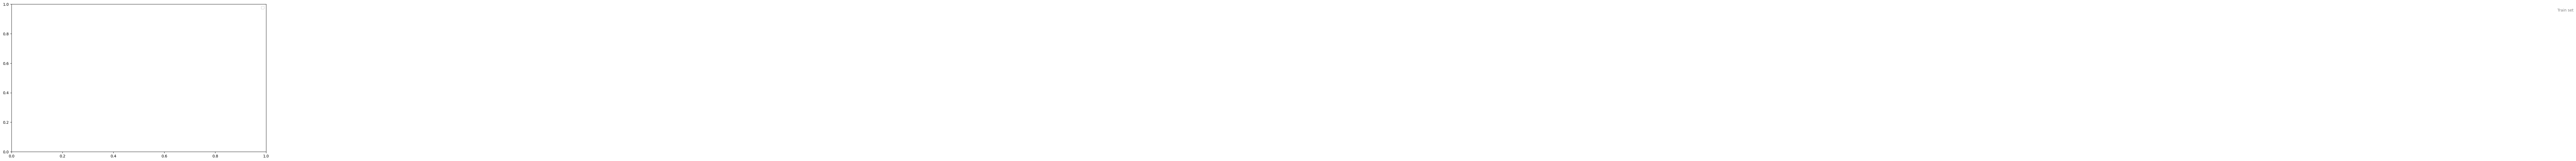

In [11]:
errors = {
    'MODEL':[],
    'INPUTS':[],
    'R2 OSA TRAIN':[],
    'R2 OSA TEST':[],
    'R2 OSA TOTAL':[],
    'R2 FS TRAIN':[],
    'R2 FS TEST':[],
    'R2 FS TOTAL':[],
    'RMSE OSA TRAIN':[],
    'RMSE OSA TEST':[],
    'RMSE OSA TOTAL':[],
    'RMSE FS TRAIN':[],
    'RMSE FS TEST':[],
    'RMSE FS TOTAL':[],
    }

fig, ax   = plt.subplots(1,1, figsize=(12,7))
for model, yhat, yhat_OSA in yhats:
    model_name = model.split('.')[0]
    model_input = model.split('.')[1]
    errors['MODEL'].append(model_name)
    errors['INPUTS'].append(model_input)
    #if not model_name in ['PolyReg', 'LinReg', 'MLP']: continue
    print(model)
    print('R2 Train (OSA):', r2_score(y_te.ravel()[:502], yhat_OSA.ravel()[:502]))
    errors['R2 OSA TRAIN'].append(r2_score(y_te.ravel()[:502], yhat_OSA.ravel()[:502]))
    print('R2 Test (OSA):', r2_score(y_te.ravel()[502:], yhat_OSA.ravel()[502:]))
    errors['R2 OSA TEST'].append(r2_score(y_te.ravel()[502:], yhat_OSA.ravel()[502:]))
    print('R2 Full  (OSA):', r2_score(y_te.ravel(), yhat_OSA.ravel()))
    errors['R2 OSA TOTAL'].append(r2_score(y_te.ravel(), yhat_OSA.ravel()))
    print('R2 Train (FS): ', r2_score(y_te.ravel()[:502], yhat.ravel()[:502]))
    errors['R2 FS TRAIN'].append(r2_score(y_te.ravel()[:502], yhat.ravel()[:502]))
    print('R2 Test (FS): ', r2_score(y_te.ravel()[502:], yhat.ravel()[502:]))
    errors['R2 FS TEST'].append(r2_score(y_te.ravel()[502:], yhat.ravel()[502:]))
    print('R2 Full  (FS): ', r2_score(y_te.ravel(), yhat.ravel()))
    errors['R2 FS TOTAL'].append(r2_score(y_te.ravel()[:], yhat.ravel()[:]))
    print('RMSE Train (OSA):', mean_squared_error(y_te.ravel()[:502], yhat_OSA.ravel()[:502])**0.5)
    errors['RMSE OSA TRAIN'].append(mean_squared_error(y_te.ravel()[:502], yhat_OSA.ravel()[:502])**0.5)
    print('RMSE Test (OSA):', mean_squared_error(y_te.ravel()[502:], yhat_OSA.ravel()[502:])**0.5)
    errors['RMSE OSA TEST'].append(mean_squared_error(y_te.ravel()[502:], yhat_OSA.ravel()[502:])**0.5)
    print('RMSE Full  (OSA):', mean_squared_error(y_te.ravel(), yhat_OSA.ravel())**0.5)
    errors['RMSE OSA TOTAL'].append(mean_squared_error(y_te.ravel()[:], yhat_OSA.ravel()[:])**0.5)
    print('RMSE Train (FS): ', mean_squared_error(y_te.ravel()[:502], yhat.ravel()[:502])**0.5)
    errors['RMSE FS TRAIN'].append(mean_squared_error(y_te.ravel()[:502], yhat.ravel()[:502])**0.5)
    print('RMSE Test (FS): ', mean_squared_error(y_te.ravel()[502:], yhat.ravel()[502:])**0.5)
    errors['RMSE FS TEST'].append(mean_squared_error(y_te.ravel()[502:], yhat.ravel()[502:])**0.5)
    print('RMSE Full  (FS): ', mean_squared_error(y_te.ravel(), yhat.ravel())**0.5)
    errors['RMSE FS TOTAL'].append(mean_squared_error(y_te.ravel()[:], yhat.ravel()[:])**0.5)
    if not 'LinReg' in model: continue
    ax.plot(yhat, label=' - '.join(model.split('.')[:-1]))
    ax.plot(y_te, 'k--', label='Real data')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Normalized Output (Liquid Rate)')
    ax.set_title('Model comparison with real data (Free run simulation)')
    ax.fill_between(np.arange(0, len(yhat)), 0, 1, where = np.arange(0, len(yhat))<=502,
                facecolor ='grey', alpha = 0.25)
ax.legend()
ax.set_xlim(0,None)
ax.set_ylim(0,1)
ax.text(10, 0.95, 'Train set', color='grey')
#fig.savefig(f'./outputs/final_results/best_model_static.pdf')

In [12]:
results_df = pd.concat([pd.DataFrame(errors), pd.DataFrame(times).iloc[:,2:]],axis='columns').sort_values('R2 FS TOTAL', ascending=False).reset_index().sort_values('index').reset_index()
results_df['BEST LAG'] = np.array([lag[-1] for lag in lags])
results_df['level_0'] += 1
results_df = results_df[['MODEL', 'INPUTS', 'BEST LAG', 'R2 OSA TRAIN', 'R2 FS TRAIN', 'RMSE OSA TRAIN', 'RMSE FS TRAIN', 'R2 OSA TOTAL', 'R2 FS TOTAL', 'RMSE OSA TOTAL', 'RMSE FS TOTAL', 'TIME MEAN', 'level_0']].round(3)

In [13]:
print(results_df.to_latex(index=False,))

\begin{tabular}{llrrrrrrrrrrr}
\toprule
MODEL & INPUTS & BEST LAG & R2 OSA TRAIN & R2 FS TRAIN & RMSE OSA TRAIN & RMSE FS TRAIN & R2 OSA TOTAL & R2 FS TOTAL & RMSE OSA TOTAL & RMSE FS TOTAL & TIME MEAN & level_0 \\
\midrule
SVM & SISO-static & 20 & 0.903000 & 0.719000 & 0.082000 & 0.140000 & 0.880000 & 0.726000 & 0.095000 & 0.143000 & 0.007000 & 11 \\
KNN & SISO-static & 5 & 1.000000 & 0.685000 & 0.000000 & 0.148000 & 0.926000 & 0.703000 & 0.075000 & 0.149000 & 0.001000 & 14 \\
DecisionTree & SISO-static & 17 & 0.904000 & 0.738000 & 0.082000 & 0.135000 & 0.857000 & 0.715000 & 0.103000 & 0.146000 & 0.001000 & 13 \\
RandomForest & SISO-static & 19 & 0.964000 & 0.772000 & 0.050000 & 0.126000 & 0.931000 & 0.762000 & 0.072000 & 0.134000 & 0.400000 & 5 \\
GradientBoosting & SISO-static & 16 & 0.978000 & 0.757000 & 0.039000 & 0.130000 & 0.940000 & 0.751000 & 0.067000 & 0.137000 & 0.864000 & 8 \\
ExtraTrees & SISO-static & 16 & 0.975000 & 0.756000 & 0.042000 & 0.130000 & 0.935000 & 0.756000 & 

In [14]:
import json
parameters = {
    'Estimator':[],
    'INPUTS':[],
    'Parameter name':[],
    'Parameter value':[],
    }
for model, par in best_pars:
    count = 0
    plist = list(par.keys())
    plist.sort()
    for parname in plist:
        if count == 0:
            parameters['Estimator'].append(model.split('.')[0])
            count = 1
        else:
            parameters['Estimator'].append("")
        parameters['INPUTS'].append(model.split('.')[1])
        parameters['Parameter name'].append(parname)
        parameters['Parameter value'].append(par[parname])

parameters = pd.DataFrame(parameters)
parameters_final = parameters[parameters['INPUTS'] == 'SISO']
parameters_final.loc[:,'MISO'] = parameters[parameters['INPUTS'] == 'MISO']['Parameter value'].values
parameters = parameters_final[['Estimator', 'Parameter name', 'Parameter value', 'MISO']]


In [15]:
print(pd.DataFrame(parameters).to_latex(index=False))

\begin{tabular}{llll}
\toprule
Estimator & Parameter name & Parameter value & MISO \\
\midrule
\bottomrule
\end{tabular}



In [16]:
plt.style.use(['science', 'ieee', 'notebook'])
plot_model = ['GradientBoosting', 'ExtraTrees', 'RandomForest', 'MLP']

fig, axs   = plt.subplots(2,1, figsize=(20,16))
for model, yhat, yhat_OSA in yhats:
    model_name = model.split('.')[0]
    #if not model_name in ['PolyReg', 'LinReg', 'MLP']: continue
    if not model_name in plot_model: continue
    if 'MISO' in model:
        ind = 1
    else:
        ind = 0
    axs[ind].plot(yhat, label=', '.join(model.split('.')[:-1]))
    print(model)
    print('RMSE Train (OSA):', mean_squared_error(y_te.ravel()[:502], yhat_OSA.ravel()[:502])**0.5)
    print('RMSE Full  (OSA):', mean_squared_error(y_te.ravel(), yhat_OSA.ravel())**0.5)
    print('RMSE Train (FS): ', mean_squared_error(y_te.ravel()[:502], yhat.ravel()[:502])**0.5)
    print('RMSE Full  (FS): ', mean_squared_error(y_te.ravel(), yhat.ravel())**0.5)
axs[0].set_title('Model comparison with real data (Free run simulation, SISO)', fontsize=title_font)
axs[1].set_title('Model comparison with real data (Free run simulation, MISO)', fontsize=title_font)
for ax in axs:
    ax.plot(y_te, 'o', label='Real data')
    ax.set_xlabel('Time (days)', fontsize=label_font)
    ax.set_ylabel('Normalized Output (Liquid Rate)', fontsize=label_font)
    ax.fill_between(np.arange(0, len(yhat)), 0, 1, where = np.arange(0, len(yhat))<=502,
                facecolor ='grey', alpha = 0.25)
    ax.legend(fontsize=label_font)
    ax.set_xlim(0,None)
    ax.set_ylim(0,1)
    ax.text(10, 0.05, 'Train set', color='grey', fontsize=title_font)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#fig.savefig(f'./outputs/{plot_model}_comparison_big.pdf')
fig.savefig(f'./outputs/final_results/global_comparison_big_static.pdf')

RandomForest.SISO-static.W1
RMSE Train (OSA): 0.05010327705802506
RMSE Full  (OSA): 0.07181185645700709
RMSE Train (FS):  0.1260471742542425
RMSE Full  (FS):  0.1335237790837083
GradientBoosting.SISO-static.W1
RMSE Train (OSA): 0.03921636024536701
RMSE Full  (OSA): 0.06678938134920226
RMSE Train (FS):  0.12998182858321533
RMSE Full  (FS):  0.13655890063322673
ExtraTrees.SISO-static.W1
RMSE Train (OSA): 0.041610644152329394
RMSE Full  (OSA): 0.06995330887064265
RMSE Train (FS):  0.13027160779596925
RMSE Full  (FS):  0.13510479448997356
MLP.SISO-static.W1
RMSE Train (OSA): 0.07608871233337626
RMSE Full  (OSA): 0.09128967794085423
RMSE Train (FS):  0.13327376145489644
RMSE Full  (FS):  0.13725541753289172
RandomForest.MISO-static.W1
RMSE Train (OSA): 0.03830268376498742
RMSE Full  (OSA): 0.0676927118041357
RMSE Train (FS):  0.12128111520067428
RMSE Full  (FS):  0.1270833968911495
GradientBoosting.MISO-static.W1
RMSE Train (OSA): 0.026734850411262338
RMSE Full  (OSA): 0.07063767075183294
R